<a href="https://colab.research.google.com/github/juanom07/tpe-teoinfo-2020/blob/master/tpe_teoinfo_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cv2 as cv
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import heapq
import os
import pickle

from google.colab import drive
# drive.mount('/content/gdrive/')

imgWillOriginal = cv.imread("ImagenesWill/Will(Original).bmp")[:,:,0]
imgWill1 = cv.imread("ImagenesWill/Will_1.bmp")[:,:,0]
imgWill2 = cv.imread("ImagenesWill/Will_2.bmp")[:,:,0]
imgWill3 = cv.imread("ImagenesWill/Will_3.bmp")[:,:,0]
imgWill4 = cv.imread("ImagenesWill/Will_4.bmp")[:,:,0]
imgWill5 = cv.imread("ImagenesWill/Will_5.bmp")[:,:,0]
imgWillCanal2 = cv.imread("ImagenesWill/Will_Canal2.bmp")[:,:,0]
imgWillCanal8 = cv.imread("ImagenesWill/Will_Canal8.bmp")[:,:,0]
imgWillCanal10 = cv.imread("ImagenesWill/Will_Canal10.bmp")[:,:,0]
imgWillEj2 = cv.imread("ImagenesWill/Will_ej2.bmp")[:,:,0]
listado_de_imagenes = [imgWill1, imgWill2, imgWill3, imgWill4, imgWill5]
plt.imshow(imgWillOriginal)
plt.show()

factor 0.9788775174153741


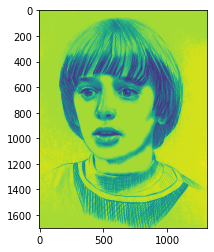

In [ ]:

import math

def getCorrelacionCruzada(imagenA, imagenB, mediaA, mediaB):
    sxy = 0
    h,w = imagenA.shape
    for (x,y) in zip(np.nditer(imagenA),np.nditer(imagenB)):
        sxy = sxy + ((x - mediaA) * (y - mediaB))
    sxy = sxy/(h*w)
    return sxy

def getFactorCorrelacion(imagenA, imagenB):
    mediaA = np.mean(imagenA)
    mediaB = np.mean(imagenB)
    desvioA = np.std(imagenA)
    desvioB =  np.std(imagenB)
    sxy = getCorrelacionCruzada(imagenA, imagenB, mediaA, mediaB)
    return sxy/(desvioA*desvioB)

# def obtenerImgMasParecida(img, imgList):
#     max = -math.inf
#     imgMasParecida = 0
#     for item in imgList:
#         r = getFactorCorrelacion(img, item)
#         if r > max:
#           max = r
#           imgMasParecida = item;
#     return max,imgMasParecida

# r, imgMasParecida = obtenerImgMasParecida(imgWillOriginal, listado_de_imagenes)
# print (r)
# plt.imshow(imgMasParecida)
# plt.show()

def recuperarFactorCorrelacion(elem):
    return elem[0]

def recuperarImagen(elem):
    return elem[1]

def obtenerImagenesOrdenadas(img, imgList):
    output = []
    for item in imgList:
        r = getFactorCorrelacion(img, item)
        elemento = [r, item]
        output.append(elemento)
    output.sort(key=recuperarFactorCorrelacion, reverse=True)
    return output


imagenesOrdenadas = obtenerImagenesOrdenadas(imgWillOriginal, listado_de_imagenes)
imgMasParecida = recuperarImagen(imagenesOrdenadas[0])
FactorimgMasParecida = recuperarFactorCorrelacion(imagenesOrdenadas[0])
print ("factor", FactorimgMasParecida)
plt.imshow(imgMasParecida)
plt.show()

[1055, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9512, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 33839, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 53775, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 56035, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 56338, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 64869, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 78567, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 94398, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 103929, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 108459, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 116314, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 185314, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 802647, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 442737, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19212]
[1041, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9400, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 33643, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

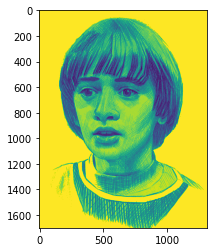

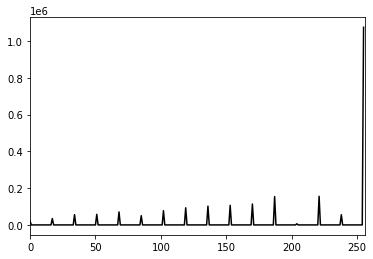

In [ ]:
# Genera un arreglo de 256 con la cantidad de veces que aparece ese color en la imagen
def obtener_ocurrencia_pixeles(imagen):
    result = [0]*256
    for i in imagen:
        for j in i:
            result[j] = result[j] + 1

    return result

#Genera el grafico del histograma de una imagen
def obtener_histograma(imagen):
    color = ('b')
    histr = cv.calcHist([imagen],[0],None,[256],[0,256])
    plt.plot(histr,color = 'black' )
    plt.xlim([0,256])
    return plt

def getMedia(distr):
    media = 0
    for i in range(len(distr)):
        media += distr[i]*i
    media = media/(h*w)
    return media

def getDesvio(distr, media):
    desvio = 0
    for i in range(len(distr)):
        desvio += (distr[i] *  (i - media)**2)
    desvio = desvio/(h*w)
    return math.sqrt(desvio)

histograma = obtener_ocurrencia_pixeles(imgWillOriginal)
histograma2 = obtener_ocurrencia_pixeles(img)
histograma3 = obtener_ocurrencia_pixeles(imgWillEj2)
# obtener_histograma(imgWillOriginal)
print (histograma)
print (histograma2)
print (histograma3)
media = getMedia(histograma)
desvio = getDesvio(histograma, media)
print (media, desvio)
media2 = getMedia(histograma2)
desvio2 = getDesvio(histograma2, media2)
print (media2, desvio2)
media3 = getMedia(histograma3)
desvio3 = getDesvio(histograma3, media3)
print (media3, desvio3)
# plt.imshow(imgWillOriginal)
# plt.show()
# plt.imshow(img)
# plt.show()
plt.imshow(imgWillEj2)
plt.show()
obtener_histograma(imgWillEj2)
plt.show()

In [ ]:
h, w = imgWillOriginal.shape

def obtener_probs_pixeles(imagen):
    result = [0]*256
    probs = {}
    for i in imagen:
        for j in i:
            result[j] = result[j] + 1
    for i in range(len(result)):
        if (result[i] != 0):
            probs[i] = result[i]/(h*w)
    return probs

def makeTree(probs):
    q = []
    for key,value in probs.items():
        heapq.heappush(q,(value,0,key))

    while len(q) > 1:
        e1 = heapq.heappop(q) # El símbolo menos probable
        e2 = heapq.heappop(q) # El segundo menos probable
        
        # Este nuevo nodo tiene probabilidad e1[0]+e2[0] y profundidad mayor al nuevo nodo
        nw_e = (e1[0]+e2[0],max(e1[1],e2[1])+1,[e1,e2])
        heapq.heappush(q,nw_e)
    return q[0] # Devolvemos el arbol sin la fila


def make_dictionary(tree):
    res = {} # La estructura que vamos a devolver
    search_stack = [] # Pila para DFS
    # El último elemento de la lista es el prefijo!
    search_stack.append(tree+("",)) 
    while len(search_stack) > 0:
        elm = search_stack.pop()
        if type(elm[2]) == list:
            # En este caso, el nodo NO es una hoja del árbol, es decir que tiene nodos hijos
            prefix = elm[-1]
            search_stack.append(elm[2][1]+(prefix+"0",)) # El hijo izquierdo tiene "0" en el prefijo
            search_stack.append(elm[2][0]+(prefix+"1",)) # El hijo derecho tiene "1" en el prefijo
            continue
        else:
            # El nodo es una hoja del árbol, así que obtenemos el código completo y lo agregamos
            code = elm[-1]
            res[elm[2]] = code
        pass
    return res

def encode(dic, image):
    res = ''
    it = np.nditer(image)
    for x in it:
        pixel = int(x)
        code = dic[pixel]
        res = res + code
    res = '1' + res
    # Agregamos ceros para que la longitud del resultado sea un múltiplo de 8
    head = (8 - len(res) % 8) * '0'
    res = head + res
    return res # Convertimos a entero! (2 porque es base 2)

def getHeader(probs, h, w):
    obj = {}
    obj['h'] = h
    obj['w'] = w
    obj["probs"] = probs
    header = pickle.dumps(obj)
    return header

def toBytes(code):
    lista_bytes = []
    for i in range(0, len(code), 8):
        # me quedo con 8 caracteres de la lista de bits
        ocho_bits = code[i:i+8]
        n = int(ocho_bits, 2)
        byte = bytes([n])
        lista_bytes.append(byte)
    return lista_bytes

def writeFile(nombreArchivo, header, arrBytes):
    with open(nombreArchivo, 'wb') as f:
        pickle.dump(header, f)
        for byte in arrBytes:
            f.write(byte)
    f.close()

def readFile(nombreArchivo):
    bytes_recuperados = []
    with open(nombreArchivo, 'rb') as f:
        header = pickle.load(f)
        while True:
            byte = f.read(1)
            if byte:
                bytes_recuperados.append(byte)
            else:
                break
    f.close()
    return header, bytes_recuperados


def compress(img, probs, name):
    tree = makeTree(probs)
    dic = make_dictionary(tree)
    code = encode(dic, img)
    header = getHeader(probs, h, w)
    data = toBytes(code)
    writeFile(name, header, data)

probsOriginal = obtener_probs_pixeles(imgWillOriginal)
probsImgMasParecida = obtener_probs_pixeles(imgMasParecida)
probsImgWillEj2 = obtener_probs_pixeles(imgWillEj2)

compress(imgWillOriginal, probsOriginal, 'WillOriginal.teoinfo') # inciso a)
compress(imgMasParecida, probsOriginal, 'imgMasParecida.teoinfo') # inciso b)
compress(imgWillEj2, probsOriginal, 'imgWillEj2.teoinfo') # inciso c)
compress(imgWillEj2, probsImgWillEj2, 'imgWillEj2CodigoPropio.teoinfo') # inciso d)


print('Tamaño de archivo: {} bytes'.format(os.path.getsize('WillOriginal.teoinfo')))
print('Tamaño de archivo: {} bytes'.format(os.path.getsize('imgMasParecida.teoinfo')))
print('Tamaño de archivo: {} bytes'.format(os.path.getsize('imgWillEj2.teoinfo')))
print('Tamaño de archivo: {} bytes'.format(os.path.getsize('imgWillEj2CodigoPropio.teoinfo')))




Tamaño de archivo: 862030 bytes
Tamaño de archivo: 831736 bytes
Tamaño de archivo: 1548565 bytes
Tamaño de archivo: 812720 bytes


In [ ]:
def createImage(code, h, w):
    img = np.zeros([h,w])
    for i in range(h):
        for j in range(w):
            img[i][j] = int(code[i*w + j])
    return img

def decode(tree, code):
    output = []
    p = tree
    for bit in code :
        if bit == '0' : p = p[2][1]     # Head up the left branch
        else          : p = p[2][0]    # or up the right branch
        if type(p[2]) == type(0):
            output.append(p[2])            # found a character. Add to output
            p = tree                 # and restart for next character
    return output

def decodeData(data):
    result = ""
    for byte in data:
        bits = bin(byte[0])[2:].zfill(8)
        result += bits
    done = False
    while not done:
        if result[0] == '0':
            result = result[1:] # saco los 0's que tiene por demas la secuencia
        else:
            done = True
            result = result[1:] # saco el 1 que delimita el inicio de la secuencia
    return result

def decodeHeader(header):
    dic = pickle.loads(header)
    return dic['h'], dic['w'], dic['probs']

def decodeImage(header, data):
    h, w, probs = decodeHeader(header)
    tree = makeTree(probs)
    code = decode(tree, decodeData(data))
    img = createImage(code, h, w)
    return img

def readFile(nombreArchivo):
    bytes_recuperados = []
    with open(nombreArchivo, 'rb') as f:
        header = pickle.load(f)
        while True:
            byte = f.read(1)
            if byte:
                bytes_recuperados.append(byte)
            else:
                break
    f.close()
    return header, bytes_recuperados

def decompress(name):
    headerOfFile, dataOfFile = readFile(name)
    img = decodeImage(headerOfFile, dataOfFile)
    plt.imshow(img)
    plt.show()

decompress('WillOriginal.teoinfo') # inciso a)
decompress('imgMasParecida.teoinfo') # inciso b)
decompress('imgWillEj2.teoinfo') # inciso c)
decompress('imgWillEj2CodigoPropio.teoinfo') # inciso d)

In [121]:
def getMatrizConjunta(imagenA, imagenB, probs):
    coloresA = []
    for key, value in probs.items():
        coloresA.append(key)
    # print(coloresA)
    mat = np.zeros([len(coloresA),len(coloresA)]) # fila B / columna A
    for i in range(h):
        for j in range(w):
            a = coloresA.index(int(imagenA[i][j]))
            b = coloresA.index(int(imagenB[i][j]))
            mat[b][a] += 1
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            mat[i][j] = mat[i][j]/(h*w)
    return mat

def getMatrizCondicional(conjunta, probs):
    mat = np.zeros(conjunta.shape)
    coloresA = []
    for key, value in probs.items():
        coloresA.append(key)
    # print(coloresA)
    for i in range(conjunta.shape[0]):
        for j in range(conjunta.shape[1]):
            prob = probs[coloresA[j]]
            mat[i][j] = conjunta[i][j]/prob
    return mat

def getMatrizTransicion(imagenA, imagenB):
    probs = obtener_probs_pixeles(imagenA)
    conjunta = getMatrizConjunta(imagenA, imagenB, probs)
    transicion = getMatrizCondicional(conjunta, probs)
    return transicion

transicionCanal2 = getMatrizTransicion(imgWillOriginal, imgWillCanal2) 
transicionCanal8 = getMatrizTransicion(imgWillOriginal, imgWillCanal8)
transicionCanal10 = getMatrizTransicion(imgWillOriginal, imgWillCanal10)
print (transicionCanal2)
print (transicionCanal8)
print (transicionCanal10)




[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.07924927e-05 7.47526621e-06 0.00000000e+00 0.00000000e+00]
 [5.51658768e-01 4.97897393e-01 4.48506162e-01 3.90385867e-01
  3.28294816e-01 2.59434130e-01 1.97305338e-01 1.47173750e-01
  1.10161232e-01 7.81302620e-02 5.45736177e-02 3.53439827e-02
  1.96962993e-02 9.77640233e-03 5.95161462e-03 7.65146783e-03]
 [1.11848341e-01 1.25525652e-01 1.37651822e-01 1.42296606e-01
  1.43910056e-01 1.44289822e-01 1.37646642e-01 1.27623557e-01
  1.17958008e-01 1.04196134e-01 8.82822080e-02 7.02237048e-02
  5.72865515e-02 3.99104463e-02 2.97016061e-02 2.91484489e-02]
 [0.00000000e+00 1.99747687e-03 1.97996395e-03 2.75220828e-03
  4.10457750e-03 6.95800348e-03 1.21938060e-02 1.64063793e-02
  2.31572703e-02 3.03283973e-02 4.02917231e-02 5.07935416e-02
  6.25910617e-02 7.44175210e-02 8.22723197e-02 8.61440766e-02]
 [2.